In [ ]:
import torch
from torch import nn
from torch_utils.moduler import data_setup,engine,predictions,model_builder
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchinfo import summary



In [10]:
# set device

device = "mps" if torch.backends.mps.is_available() else "cuda" 

In [13]:
from pathlib import Path 
img_path = Path("/Users/frankdzzz/Jupyter Notes/food_data/pizza_steak_sushi")
train_dir = img_path/ "train" 
test_dir = img_path/ "test"

test_dir, train_dir

(PosixPath('/Users/frankdzzz/Jupyter Notes/food_data/pizza_steak_sushi/test'),
 PosixPath('/Users/frankdzzz/Jupyter Notes/food_data/pizza_steak_sushi/train'))

In [14]:
#from Table 3 in ViT Paper
IMG_SIZE = 224

#manual transforms:

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"my manual transforms: {manual_transforms}")

my manual transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [17]:

NUM_WORKERS = torch.cpu

<module 'torch.cpu' from '/Library/anaconda3/envs/my_first_env/lib/python3.12/site-packages/torch/cpu/__init__.py'>

In [18]:
import os 
BATCH_SIZE = 32 # in order to make sure we can run the code, this is lower than the ViT paper (4096);

NUM_WORKERS = os.cpu_count()
train_dataloader,test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,

)
train_dataloader,test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x12d7abc80>,
 ['pizza', 'steak', 'sushi'])

In [21]:
#VISUALize one image to get information
img_batch, label_batch = next(iter(train_dataloader))
#get batch
img,label = img_batch[0],label_batch[0]
#get the first one img
img,label

/Library/anaconda3/envs/my_first_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


(tensor([[[0.6039, 0.6431, 0.6902,  ..., 0.9961, 0.9961, 0.9961],
          [0.6118, 0.6510, 0.7059,  ..., 0.9961, 0.9961, 0.9961],
          [0.6314, 0.6745, 0.7333,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.1608, 0.1608, 0.1569,  ..., 0.2706, 0.2706, 0.2745],
          [0.1490, 0.1412, 0.1373,  ..., 0.2627, 0.2549, 0.2549],
          [0.1412, 0.1255, 0.1137,  ..., 0.2392, 0.2314, 0.2235]],
 
         [[0.6196, 0.6588, 0.7059,  ..., 0.9961, 0.9961, 0.9961],
          [0.6275, 0.6667, 0.7216,  ..., 0.9961, 0.9961, 0.9961],
          [0.6471, 0.6902, 0.7490,  ..., 0.9961, 0.9961, 0.9961],
          ...,
          [0.1569, 0.1569, 0.1529,  ..., 0.2627, 0.2627, 0.2627],
          [0.1373, 0.1333, 0.1294,  ..., 0.2510, 0.2431, 0.2431],
          [0.1255, 0.1137, 0.1059,  ..., 0.2275, 0.2196, 0.2118]],
 
         [[0.6157, 0.6549, 0.7059,  ..., 0.9961, 0.9961, 0.9961],
          [0.6235, 0.6667, 0.7216,  ..., 0.9961, 0.9961, 0.9961],
          [0.6510, 0.6941, 0.7529,  ...,

In [22]:
img.shape

torch.Size([3, 224, 224])

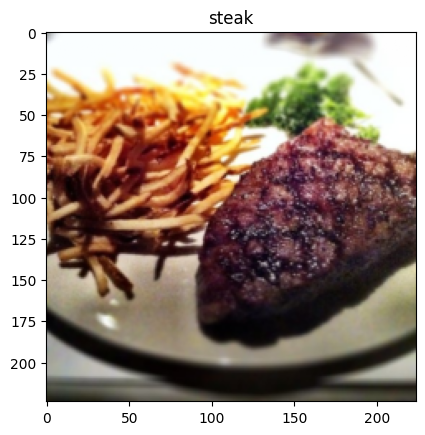

In [23]:
#plot 
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.show()

In [25]:
# Create example values

height = 224
width = 224
color_channels = 3 
patch_size = 16

patch_nums = int(height * width / (patch_size * patch_size))
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {patch_nums}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [26]:
'''
embedding layer
'''
#input shape
embedding_layer_input_shape = (height,width,color_channels)

#output shape
embedding_layer_output_shape = (patch_nums,patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


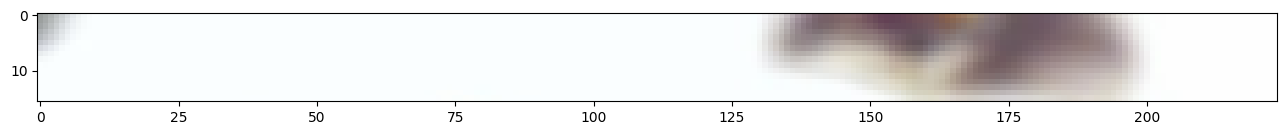

In [31]:
#visualize a portion then patch it.
img_permute = img.permute(1,2,0)

patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(img_permute[:patch_size,:,:])

In [32]:
img.shape

torch.Size([3, 224, 224])

In [34]:
img_size = 224
patch_nums = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {patch_nums}\nPatch size: {patch_size} pixels x {patch_size} pixels")

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


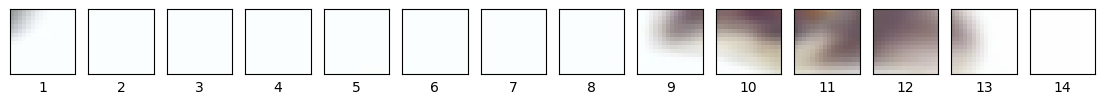

In [38]:
# plot the patching progress
fig,axis = plt.subplots(nrows=1,
             ncols=int(patch_nums),
             figsize=(patch_nums,patch_nums),
             sharex=True,
             sharey=True,
             )


for i, patch in enumerate(range(0,img_size,patch_size)):
    axis[i].imshow(img_permute[:patch_size,patch:patch+patch_size,:])
    axis[i].set_xlabel(i+1)
    axis[i].set_xticks([])
    axis[i].set_yticks([])



Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


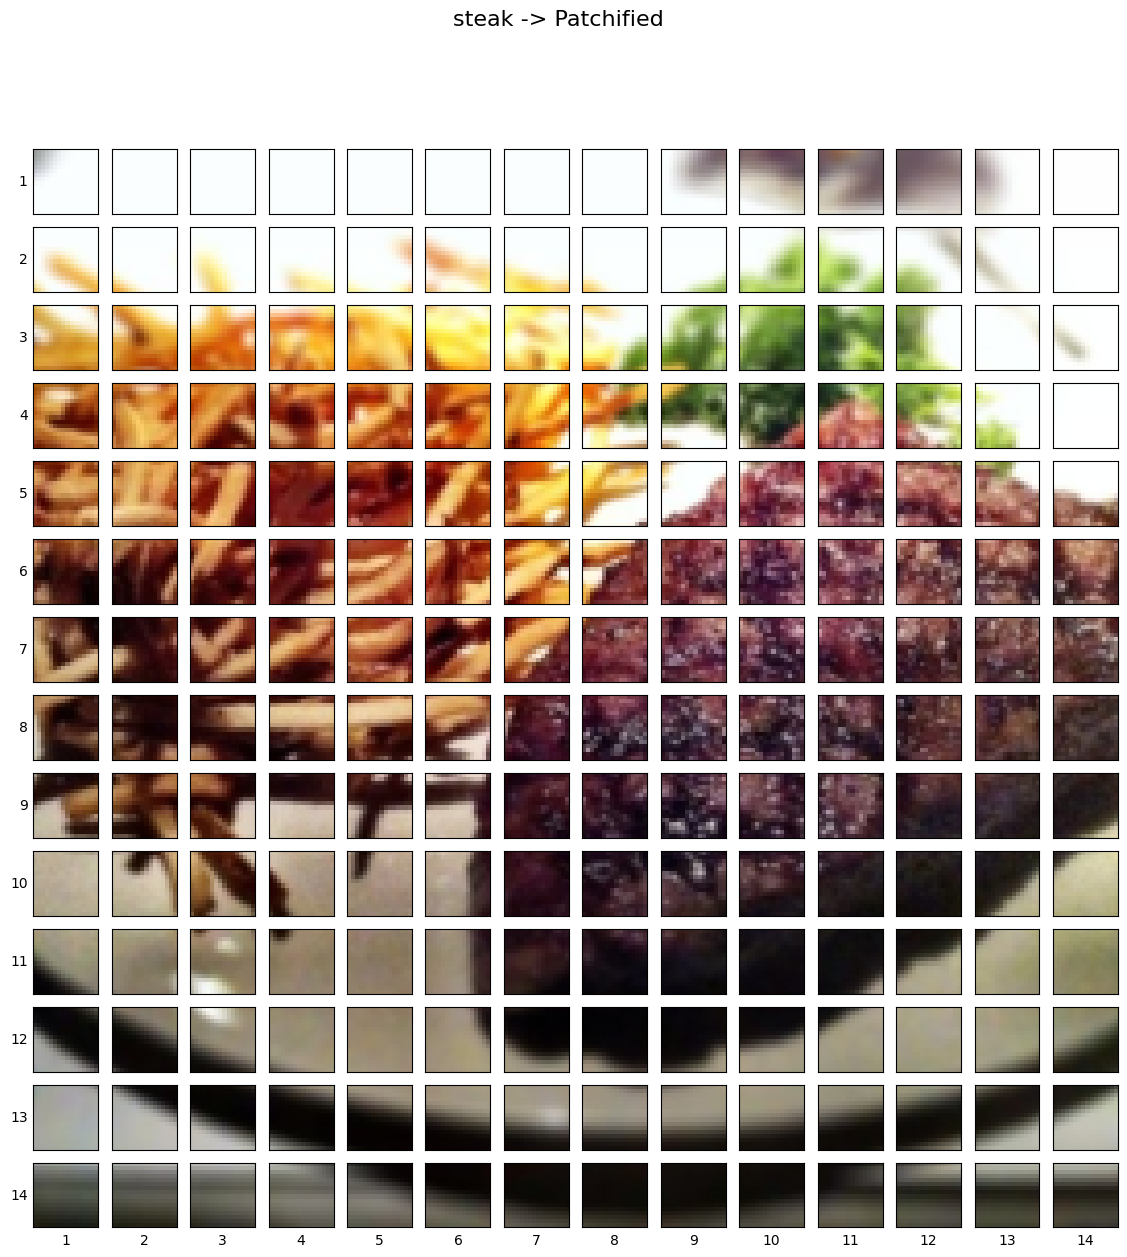

In [39]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(img_permute[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

Building the first layer with CNN and Flatten

the input is Input (2D image): (224, 224, 3) -> (height, width, color channels)

the output is Output (flattened 2D patches): (196, 768) -> (number of patches, embedding dimension)

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

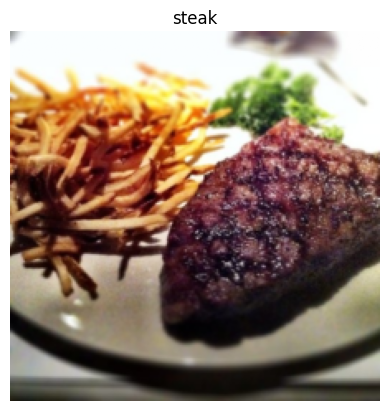

In [41]:
Conv2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size, # kernel_size = patch_size * patch_size, a squre
    stride=patch_size, # no competitive sampling
    padding=0
)

# visualize
plt.imshow(img_permute)
plt.title(class_names[label])
plt.axis(False)


In [42]:
img_out_of_CNN = Conv2d(img.unsqueeze(0))
print(img_out_of_CNN.shape)

torch.Size([1, 768, 14, 14])


In [ ]:
flatten = nn.Flatten(
    start_dim=2,
    end_dim=3,
) # only the last two dimension we want to flatten

In [46]:
# 1. Turn image into feature maps
image_out_of_conv = Conv2d(img.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 2. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


Desired output (flattened 2D patches): (196, 768) -> ${N \times\left(P^{2} \cdot C\right)}$


Current shape: (1, 768, 196)

In [55]:
img_size_required_by_the_paper = image_out_of_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape: {img_size_required_by_the_paper.shape} -> [batch,num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch,num_patches, embedding_size]


In [60]:
img_size_required_by_the_paper.shape

torch.Size([1, 196, 768])

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

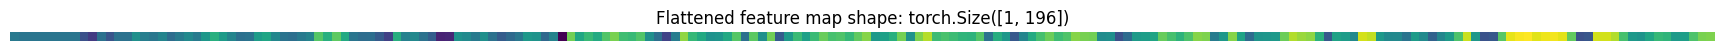

In [57]:
single_flattened_feature_map = img_size_required_by_the_paper[:,:,0]
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [71]:
#create the PatchEmbedding layer
class PatchEmbedding(nn.Module):
    '''
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    
    '''
    def __init__(self, in_channels=3,patch_size=16,embedding_dim=768):
        super().__init__()
        self.conv2d = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )
        self.flatten = nn.Flatten(
            start_dim=2,
            end_dim=3,
        )
    
    def forward(self,x):
        
        x = self.flatten(self.conv2d(x))
        return x.permute(0,2,1)


In [68]:
img.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [86]:
patch_embedding_layer = PatchEmbedding()
patch_embedded_image = patch_embedding_layer(img.unsqueeze(0))

In [87]:
patch_embedded_image.shape
random_input_image = (1, 3, 224, 224)
summary(patch_embedding_layer,input_size=random_input_image)

Layer (type:depth-idx)                   Output Shape              Param #
PatchEmbedding                           [1, 196, 768]             --
├─Conv2d: 1-1                            [1, 768, 14, 14]          590,592
├─Flatten: 1-2                           [1, 768, 196]             --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [88]:
# add class token at the beginning of the sentence
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

#create class token
class_token = nn.Parameter(torch.ones(batch_size,
                                      1,# token只有一个，这里就是1
                                      embedding_dim), 
                                      requires_grad=True) # 需要learnable 所以是 true

# the first 10 token

print(class_token[:,:,:10])
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [90]:
# add token tensor to the front of the embedding tensor
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),dim=1)
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape


(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.1241,  0.3263,  0.2202,  ..., -0.7606, -0.3262,  0.2443],
          [ 0.0031,  0.3790,  0.1699,  ..., -0.7214, -0.3253,  0.2409],
          ...,
          [ 0.0086,  0.1621, -0.0739,  ..., -0.2572, -0.1335,  0.1246],
          [-0.1124,  0.2441, -0.1257,  ..., -0.2307, -0.0867,  0.1195],
          [-0.1147,  0.2441, -0.1348,  ..., -0.2235, -0.0948,  0.1176]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [93]:
# Now for positioning embedding 
number_of_patches = int((height * width) / patch_size**2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
position_embedding = torch.ones((1,number_of_patches+1,embedding_dimension),requires_grad=True)

print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [94]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.1241, 1.3263, 1.2202,  ..., 0.2394, 0.6738, 1.2443],
         [1.0031, 1.3790, 1.1699,  ..., 0.2786, 0.6747, 1.2409],
         ...,
         [1.0086, 1.1621, 0.9261,  ..., 0.7428, 0.8665, 1.1246],
         [0.8876, 1.2441, 0.8743,  ..., 0.7693, 0.9133, 1.1195],
         [0.8853, 1.2441, 0.8652,  ..., 0.7765, 0.9052, 1.1176]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [100]:
# Putting all together: from img to embedding
# Equation 1 
torch.manual_seed(7)

#1 create patch_size
PATCH_SIZE = 16

#2 original img shape
print(f"Image tensor shape: {img.shape}")
height, width = img.shape[1], img.shape[2]

#3 get tensor and add patch dim
x = img.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

#4 patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=PATCH_SIZE,
                                       embedding_dim=768)

# 5 pass img through the patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6 create class token
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7 Prepend class token embedding to patch embedding
patch_embedding_with_class_token = torch.cat((class_token,patch_embedding),dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_with_class_token.shape}")

# 8 create position embedding
number_of_patches =  int((height * width) / patch_size**2)
patch_and_position_embedding = torch.ones(1,number_of_patches+1,embedding_dimension)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [102]:
# multihead attention layer 
# Equation 2 
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self, embedding_dim=768, num_heads=12,dropout=0,batch_first=True):
        super().__init__()
        
        # the first norm layer    
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)    
        
        #multihead attention
        self.multihead_attention = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=batch_first,
        )

    def forward(self,x):
        x = self.layer_norm(x)
        attention_output,_ = self.multihead_attention(
            query=x,
            key=x,
            value=x,
            need_weights=True
        )

        return attention_output
    

multihead_self_attention_block = MultiHeadSelfAttentionBlock(768,12)

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

        


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [107]:
# create MLP layer
# equation 3
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim=768,mlp_size=3072,dropout=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,out_features=embedding_dim),
            nn.Dropout(p=dropout),
        )

    def forward(self,x):
        return self.mlp(self.layer_norm(x))


mlp_block = MLPBlock(768,3072,0.1)

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [105]:
# create Transformer Encoder to combine 2 blocks above

class EncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim=768,
                 num_heads=12,
                 mlp_size=3072,
                 mlp_dropout=0.1,
                 attention_dropout=0,
                 ):
        super().__init__()

        self.msa_blcok = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                                          num_heads=num_heads,
                                                                          dropout=attention_dropout,)
        
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,mlp_size=mlp_size,dropout=mlp_dropout)

    def forward(self,x):
        
        x = self.msa_blcok(x) + x # the first residual connection
        
        x = self.mlp_block(x) + x # the second residual connection
        return x

In [108]:
transformer_encoder = EncoderBlock()

summary(transformer_encoder,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
EncoderBlock                             [1, 197, 768]             [1, 197, 768]             --                        True
├─MultiHeadSelfAttentionBlock: 1-1       [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm: 2-1                    [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─MultiheadAttention: 2-2           --                        [1, 197, 768]             2,362,368                 True
├─MLPBlock: 1-2                          [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm: 2-3                    [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─Sequential: 2-4                   [1, 197, 768]             [1, 197, 768]             --                        True
│  

In [111]:
#### It's time to finalize the creation of ViT ####

class ViTransformer(nn.Module):

    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__()
        # make sure the size is divisible by patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        # 4. Calculate number of patches (height * width/patch^2)

        self.patch_nums = (img_size * img_size) // patch_size**2

        # 5 class token
        self.class_token = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        # 6 position embedding
        self.position_embedding = nn.Parameter(torch.randn(1,self.patch_nums+1,embedding_dim),requires_grad=True)

        # 7. embedding dropout
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # use sequential, * for unpack the list and list generator to create all 12 layers of encoder

        self.transformer_encoder = nn.Sequential(
            *[EncoderBlock(embedding_dim=embedding_dim,
                           num_heads=num_heads,
                           mlp_size=mlp_size,
                           mlp_dropout = mlp_dropout,
                           attention_dropout=attn_dropout,) for _ in range(num_transformer_layers)]
        )

        self.classifier_block = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, # class token is the only input for linear Classifier so it is encoder_output[:,0,:] 
                                                # whose shape is (1,768) = (batch_size,embedding_dim) 
                      out_features=num_classes,
                      bias=True) 
        )

    #10 create a forward() method

    def forward(self,x):
        #get batch_size
        batch_size = x.shape[0]
        #
        class_token = self.class_token.expand(batch_size,-1,-1)
        #do  patch embedding on x
        x = self.patch_embedding(x)
        
        # concatenate the class token at the front of x
        x = torch.cat((class_token,x),dim=1)

        #add position embedding 
        x = x + self.position_embedding

        #run embedding dropout
        
        x = self.embedding_dropout(x)
        #put in MSA block
        x = self.transformer_encoder(x)

        #then classifier block

        x = self.classifier_block(x[:,0,:])

        return x


In [109]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"
# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [114]:
torch.manual_seed(7)
# demo
vit = ViTransformer(num_classes=1000)

random_image_tensor = torch.randn(1, 3, 224, 224) 

vit(random_image_tensor)

tensor([[ 2.2651e-01, -4.7902e-01, -8.3267e-01,  9.2576e-01, -7.0743e-01,
          1.0382e-01, -4.2570e-01,  4.8565e-01, -7.7437e-01,  6.0578e-01,
         -3.1645e-01, -4.8659e-01,  4.4909e-02,  7.2375e-01, -1.4887e+00,
          3.2513e-01,  3.0453e-01,  9.3331e-02,  2.7882e-01, -6.3011e-02,
         -8.1904e-02, -8.0632e-01, -6.1611e-02, -1.0792e-01, -8.6114e-01,
         -5.8400e-01,  7.0730e-01, -1.2552e-01,  7.0251e-01,  2.2022e-01,
         -2.1733e-01, -2.8520e-01,  4.7880e-01,  3.9964e-01, -3.6456e-01,
          1.2322e+00, -1.8298e-01,  2.9746e-01, -1.8571e-01,  2.3198e-01,
          4.2490e-01, -8.0682e-01,  7.6474e-01, -2.0785e-01,  9.0271e-02,
         -9.0255e-01, -7.0212e-01,  6.4005e-01,  6.7424e-01, -8.0838e-01,
         -2.7913e-01,  5.0882e-01, -1.3420e-01,  1.6558e-01, -1.1940e-01,
         -4.6742e-01, -1.1405e+00,  5.5161e-01,  7.8156e-01,  2.8860e-01,
         -4.3008e-02, -1.5284e-01, -1.1341e-01, -3.3389e-01,  2.4041e-01,
         -3.1829e-01, -5.4827e-01,  1.

In [115]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViTransformer (ViTransformer)                                     [32, 3, 224, 224]    [32, 1000]           152,064              True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (conv2d)                                            [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                                [32, 197, 768]       [32, 197, 768]       --                   True
│    └─EncoderBlock (0)                                      

In [117]:
torch.manual_seed(7)

# try train it
optimizer = torch.optim.Adam(vit.parameters(),lr=3e-3,betas=(0.9,0.999),weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device,
                       writer=False)

  0%|          | 0/10 [00:00<?, ?it/s]/Library/anaconda3/envs/my_first_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 1/10 [01:17<11:36, 77.36s/it]

Epoch: 1 | train_loss: 2.7770 | train_acc: 0.3594 | test_loss: 2.8825 | test_acc: 0.2604


 20%|██        | 2/10 [02:28<09:51, 73.88s/it]

Epoch: 2 | train_loss: 1.9457 | train_acc: 0.2695 | test_loss: 2.4853 | test_acc: 0.2604


 30%|███       | 3/10 [03:40<08:29, 72.73s/it]

Epoch: 3 | train_loss: 1.6899 | train_acc: 0.3047 | test_loss: 1.5860 | test_acc: 0.1979


 40%|████      | 4/10 [04:55<07:22, 73.73s/it]

Epoch: 4 | train_loss: 1.3611 | train_acc: 0.2734 | test_loss: 1.3710 | test_acc: 0.2604


 50%|█████     | 5/10 [06:06<06:04, 72.86s/it]

Epoch: 5 | train_loss: 1.2847 | train_acc: 0.3984 | test_loss: 1.6315 | test_acc: 0.1979


 60%|██████    | 6/10 [07:18<04:50, 72.56s/it]

Epoch: 6 | train_loss: 1.2742 | train_acc: 0.2734 | test_loss: 1.3655 | test_acc: 0.1979


 70%|███████   | 7/10 [08:29<03:36, 72.08s/it]

Epoch: 7 | train_loss: 1.1956 | train_acc: 0.4062 | test_loss: 1.2793 | test_acc: 0.2604


 80%|████████  | 8/10 [09:40<02:23, 71.50s/it]

Epoch: 8 | train_loss: 1.2076 | train_acc: 0.3047 | test_loss: 1.0517 | test_acc: 0.5417


 90%|█████████ | 9/10 [10:50<01:11, 71.28s/it]

Epoch: 9 | train_loss: 1.2950 | train_acc: 0.2695 | test_loss: 1.4911 | test_acc: 0.2604


100%|██████████| 10/10 [12:01<00:00, 72.13s/it]

Epoch: 10 | train_loss: 1.3292 | train_acc: 0.3008 | test_loss: 1.1114 | test_acc: 0.5417


In [118]:
#using pretrained model 

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

for params in pretrained_vit.parameters():
    params.requires_grad = False

torch.manual_seed(7)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [119]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [120]:
pretrained_transform = pretrained_vit_weights.transforms()
pretrained_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [122]:
train_dataloader_pre, test_dataloader_pre, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=pretrained_transform,
                                                                                       batch_size=32
                                                                                       )


In [124]:

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
torch.manual_seed(7)
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pre,
                                      test_dataloader=test_dataloader_pre,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device,writer=False)

  0%|          | 0/10 [00:00<?, ?it/s]/Library/anaconda3/envs/my_first_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
 10%|█         | 1/10 [01:09<10:29, 69.93s/it]

Epoch: 1 | train_loss: 0.7391 | train_acc: 0.7617 | test_loss: 0.4882 | test_acc: 0.8570


 20%|██        | 2/10 [02:14<08:55, 66.89s/it]

Epoch: 2 | train_loss: 0.3182 | train_acc: 0.9453 | test_loss: 0.3038 | test_acc: 0.9081


 30%|███       | 3/10 [03:19<07:41, 65.86s/it]

Epoch: 3 | train_loss: 0.2017 | train_acc: 0.9648 | test_loss: 0.2535 | test_acc: 0.8977


 40%|████      | 4/10 [04:24<06:34, 65.74s/it]

Epoch: 4 | train_loss: 0.1471 | train_acc: 0.9688 | test_loss: 0.2457 | test_acc: 0.8977


 50%|█████     | 5/10 [05:30<05:28, 65.73s/it]

Epoch: 5 | train_loss: 0.1224 | train_acc: 0.9727 | test_loss: 0.2316 | test_acc: 0.8977


 60%|██████    | 6/10 [06:35<04:21, 65.35s/it]

Epoch: 6 | train_loss: 0.1076 | train_acc: 0.9766 | test_loss: 0.2211 | test_acc: 0.8977


 70%|███████   | 7/10 [07:39<03:15, 65.05s/it]

Epoch: 7 | train_loss: 0.0869 | train_acc: 0.9805 | test_loss: 0.2253 | test_acc: 0.8977


 80%|████████  | 8/10 [08:44<02:10, 65.10s/it]

Epoch: 8 | train_loss: 0.0814 | train_acc: 0.9844 | test_loss: 0.2247 | test_acc: 0.8977


 90%|█████████ | 9/10 [09:51<01:05, 65.57s/it]

Epoch: 9 | train_loss: 0.0684 | train_acc: 0.9883 | test_loss: 0.2104 | test_acc: 0.8977


100%|██████████| 10/10 [10:56<00:00, 65.69s/it]

Epoch: 10 | train_loss: 0.0605 | train_acc: 0.9883 | test_loss: 0.2073 | test_acc: 0.8977


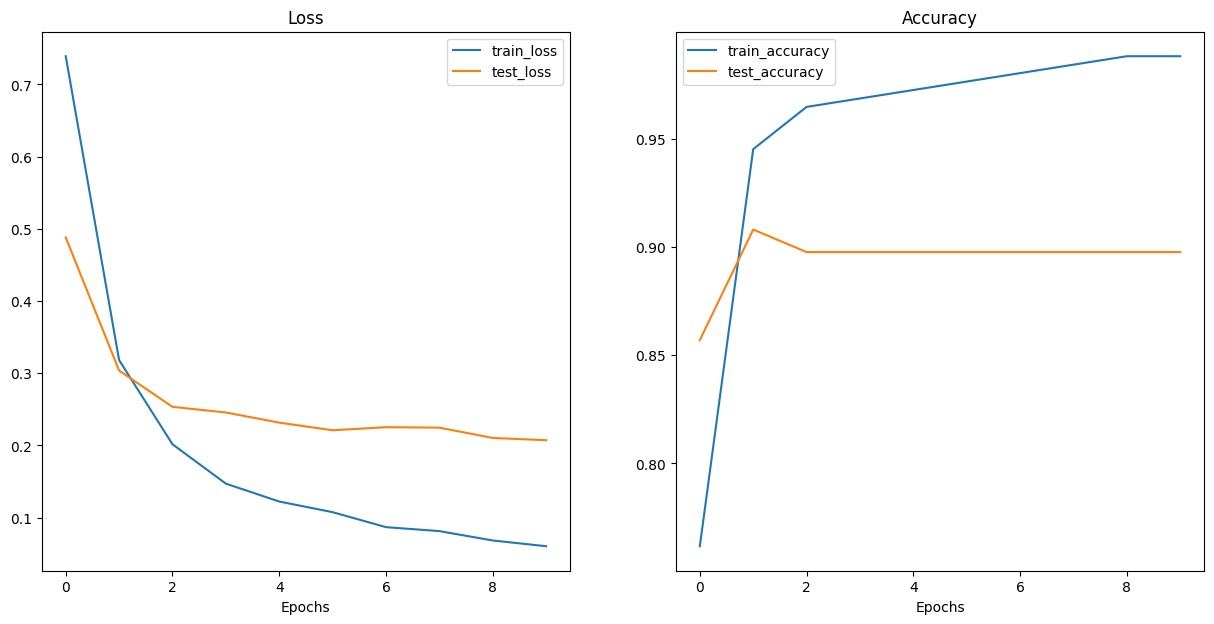

In [126]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [128]:
from torch_utils.moduler import utils
target_dir = "/Users/frankdzzz/Jupyter Notes/models"
utils.save_model(model=pretrained_vit,target_dir=target_dir,model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pt")

[INFO] Saving model to: /Users/frankdzzz/Jupyter Notes/models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pt
